In [118]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.ensemble import RakelO
from skmultilearn.model_selection import IterativeStratification
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
from mlxtend.evaluate.time_series import plot_splits
from mlxtend.evaluate.time_series import print_cv_info
from mlxtend.evaluate.time_series import print_split_info
import optuna
from functools import partial
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pickle
from collected_functions import *


Set base variable values

In [19]:
random_state = 42
np.random.seed(random_state)


In [20]:
def display_label_cardinality_error(
        y_true: pd.DataFrame,
        y_pred: np.ndarray,
    ) ->None:
    '''
    Create a scatterplot from y_true and y_pred to show accuracy of number of labels predicted.
    Created with the help of Google Gemini
    '''
    if not isinstance(y_pred, np.ndarray):
        y_pred = y_pred.toarray()

    # 1. Calculate Cardinalities (Sum across the label axis, axis=1)
    true_cardinality = np.sum(y_true, axis=1)
    pred_cardinality = np.sum(y_pred, axis=1)

    # 2. Calculate Hamming Loss per sample
    # Hamming loss for sample i = (number of mismatches) / N_LABELS
    mismatches = np.sum(y_true != y_pred, axis=1)
    hamming_loss_Score_ = mismatches / y_true.shape[1]

    # 3. Create the Visualization DataFrame
    df_error_vis = pd.DataFrame({
        'Sample_ID': [f'Sample_{i}' for i in range(y_true.shape[0])],
        'True_Cardinality': true_cardinality,
        'Predicted_Cardinality': pred_cardinality,
        'Hamming_Loss_Score_': hamming_loss_Score_,
        'Total_Errors': mismatches
    })

    fig = px.scatter(
        df_error_vis,
        x='True_Cardinality',
        y='Predicted_Cardinality',
        # Color the points by the error metric
        color='Hamming_Loss_Score_',
        # Scale the size of the points by the number of errors
        # size='Total_Errors',
        hover_data=['Sample_ID', 'Total_Errors'],
        title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
        color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
    )

    # Set axis limits and labels for a clear square comparison
    max_cardinality = y_true.shape[1]
    fig.update_xaxes(
        range=[-0.5, max_cardinality + 0.5],
        tickvals=np.arange(0, max_cardinality + 1),
        title="True Label Cardinality (Complexity)"
    )
    fig.update_yaxes(
        range=[-0.5, max_cardinality + 0.5],
        tickvals=np.arange(0, max_cardinality + 1),
        title="Predicted Label Cardinality (Model Output)"
    )

    # Add a diagonal line for perfect cardinality prediction (where X=Y)
    fig.add_shape(
        type="line", line=dict(dash='dash', color='gray'),
        x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
    )

    fig.show()

Adjust Pandas settings to display more information before truncation.

In [21]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Load combined MA and DDS training data

In [22]:
df = pd.read_parquet('combined_training_set_nontime.parquet')
print(df.shape)
df.head()

(6765, 21)


,incidentId,state,incidentTypeMA,region,maType,maPriority,supportFunction,agencyId,maId,declarationType,assistanceRequested,statementOfWork,femaDeclarationString,incidentType,incidentBeginDate,fipsStateCode,designatedIncidentTypes,declarationTitle,year,month,day
0,2024081901,CT,Severe Storm,1,FOS,High,5.0,DOI-USGS,3612EMCTDOI-USGS01,EM,USGS Field measurements of flood-water heights...,"As directed by and in coordination with FEMA, ...",EM-3612-CT,Severe Storm,2024-08-18 00:00:00+00:00,9.0,"Mud/Landslide,Severe Storm,Flood","SEVERE STORMS, FLOODING, LANDSLIDES, AND MUDSL...",2024.0,8.0,18.0
1,2024072801,FL,Tropical Storm,4,FOS,Normal,8.0,VA,4806DRFLVA02,DR,Activate VHA OEM to NRCC ESF-8 PHMS. This is a...,As directed by and in coordination with FEMA a...,DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Tropical Storm,Hurricane",HURRICANE DEBBY,2024.0,8.0,1.0
2,2024072801,FL,Tropical Storm,4,FOS,Normal,0.0,VA,4806DRFLVA01,DR,Activate VA to NRCC. This is a re-issuance of ...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Tropical Storm,Hurricane",HURRICANE DEBBY,2024.0,8.0,1.0
3,2024072801,FL,Tropical Storm,4,FOS,Normal,4.0,USDA-FS,4806DRFLUSDA-FS01,DR,Activate USFS to the NRCC. This is a re-issuan...,"As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Tropical Storm,Hurricane",HURRICANE DEBBY,2024.0,8.0,1.0
4,2024072801,FL,Tropical Storm,4,FOS,Normal,11.0,USDA-APH,4806DRFLUSDA-APH01,DR,"USDA liaison(s) to the NRCC, FEMA teams, or ot...","As directed by and in coordination with FEMA, ...",DR-4806-FL,Tropical Storm,2024-08-01 00:00:00+00:00,12.0,"Tropical Storm,Hurricane",HURRICANE DEBBY,2024.0,8.0,1.0


Transform the training data set using approach that is suitable for multiple categorical feature columns and a multilabel target. We return the transformers so that the test data set can be transformed later.

In [23]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'year',
]

target_column = 'supportFunction'

X_train, y_train = create_set(df, feature_columns, target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(464, 6) 464
0                         [7.0]
1                         [7.0]
2                         [7.0]
3    [2.0, 3.0, 7.0, 9.0, 13.0]
4        [8.0, 1.0, 10.0, 13.0]
Name: supportFunction, dtype: object


,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2013020801,CT,Severe Storm,DR,1,2013.0
1,2013020801,NH,Severe Storm,DR,1,2013.0
2,2013020801,RI,Severe Storm,DR,1,2013.0
3,2013041203,ND,Flood,EM,8,2013.0
4,2013041501,MA,Terrorist,EM,1,2013.0


In [24]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [25]:
# Since designatedIncidentTypes is a list it must be transformed differently than the other
# feature columns.
feature_columns_transform = [
    'state',
    'declarationType',
    'region',
]

X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes'],
    target_column
)

In [26]:
# Assign the year values to a variable, then drop year and incidentId from X_train_transformed.
groups_by_year = X_train_transformed['year'].values
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)
print(X_train_transformed.shape)
X_train_transformed.head()

(464, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print(y_train_transformed.shape)
y_train_transformed.head()

(464, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0


Run a variety of machine learning models and base classifiers using cross validation for model selection purposes.

In [35]:
base_svc = SVC(
        gamma='auto',
        decision_function_shape='ovo',
        class_weight='balanced',
        random_state=random_state,
        )
base_xgb = XGBClassifier(
        max_depth=12,
        random_state=0,
        n_estimators=100,
        base_score=0.5,
        )
base_gnb = GaussianNB()

br_classifier_svc = BinaryRelevance(
    classifier = base_svc,
    require_dense = [True, True]
)
br_classifier_xgb = BinaryRelevance(
    classifier = base_xgb,
    require_dense = [True, True]
)
br_classifier_gnb = BinaryRelevance(
    classifier = base_gnb,
    require_dense = [True, True]
)

cc_classifier_svc = ClassifierChain(
    classifier=base_svc, 
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_xgb = ClassifierChain(
    classifier=base_xgb,
    require_dense=[True, True],
    order = list(range(0,16)),
)
cc_classifier_gnb = ClassifierChain(
    classifier=base_gnb,
    require_dense=[True, True],
    order = list(range(0,16)),
)

classifier_rake_svc = RakelO(
   base_classifier=base_svc,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)
classifier_rake_xgb = RakelO(
   base_classifier=base_xgb,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)
classifier_rake_gnb = RakelO(
   base_classifier=base_gnb,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)

moc_svc = MultiOutputClassifier(estimator=base_svc)
moc_xgb = MultiOutputClassifier(estimator=base_xgb)
moc_gnb = MultiOutputClassifier(estimator=base_gnb)

ovr_svc = OneVsRestClassifier(estimator=base_svc)
ovr_xgb = OneVsRestClassifier(estimator=base_xgb)
ovr_gnb = OneVsRestClassifier(estimator=base_gnb)

clf_list = [
    br_classifier_svc,
    br_classifier_xgb,
    br_classifier_gnb,
    cc_classifier_svc,
    cc_classifier_xgb,
    cc_classifier_gnb,
    classifier_rake_svc,
    classifier_rake_xgb,
    classifier_rake_gnb,
    moc_svc,
    moc_xgb,
    moc_gnb,
    ovr_svc,
    ovr_xgb,
    ovr_gnb,
]

hamming_scorer = make_scorer(
    hamming_loss,
    greater_is_better=False, 
)

F1_Macro_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

F1_Samples_Avg = make_scorer(
    f1_score,
    average='macro', 
    zero_division=1,
)

scoring = {
    'Hamming':hamming_scorer,
    'F1_Macro_Avg':F1_Macro_Avg,
    'F1_Samples_Avg':F1_Samples_Avg,
    'jaccard_samples':'jaccard_samples',
}
import warnings
warnings.filterwarnings(
    "ignore", 
    category=UserWarning, 
    module="sklearn.utils.validation" 
)

for clf in clf_list:
    cross_val_results = cross_validate(clf,
                                       X_train_transformed,
                                       y_train_transformed,
                                       cv=10,
                                       scoring=scoring)

    print(f'{clf} Mean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Jaccard Samples: {cross_val_results['test_jaccard_samples'].mean()}, {cross_val_results['test_jaccard_samples'].std() }')

BinaryRelevance(classifier=SVC(class_weight='balanced',
                               decision_function_shape='ovo', gamma='auto',
                               random_state=42),
                require_dense=[True, True]) Mean Hamming: -0.28307990286771506, 0.053525765730321806

Mean F1 Macro Avg: 0.4548263375898728, 0.08349484294504565

Mean F1 Samples Avg: 0.4548263375898728, 0.08349484294504565

Mean Jaccard Samples: 0.4150472199709017, 0.033436553969198306
BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                        

XGBoost appears to be our best base model. The most promising models appear to be BinaryRelevance, ClassifierChain, and OneVsRestClassifier (MultiOutputClassification had similar results and OneVsRestClassifier is more suited to this sort of task per documentation).

The RakelO, though it did well, is being excluded due to its lack of predict_proba method.

We can start with hyperparameter tuning of BinaryRelevance and the XGBoost base classifier.

In [36]:
def objective_brxgb(trial, X, y, groups, cv_args):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=25),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 3, 10, log=True),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    
    base_XGB = XGBClassifier(**xgb_params)
    
    # The RakelO multilabel classifier (the main estimator)
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True]
    )

    scores = []    
    # cv = GroupTimeSeriesSplit(**cv_args)
    cv = KFold(**cv_args)

    # for train_index, val_index in cv.split(X, y, groups=groups):
    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # hl = hamming_loss(y_val, y_pred)
        # hl = f1_score(y_val, y_pred, average='samples', zero_division=1)
        eval_scorer = jaccard_score(y_val, y_pred, average='samples')

        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': 42}

objective_brxgb = partial(objective_brxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        )

# 3. Create and Run the Optuna Study
study_brxgb = optuna.create_study(direction="maximize") # Maximize the F1 score

study_brxgb.optimize(objective_brxgb, n_trials=30, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_brxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_brxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-15 11:56:21,120] A new study created in memory with name: no-name-0d465e63-5754-46fa-a13e-f9c4d47f2df9
Best trial: 0. Best value: 0.436215:   3%|▎         | 1/30 [00:14<07:12, 14.93s/it]

[I 2025-11-15 11:56:36,086] Trial 0 finished with value: 0.43621520828919147 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.008672111956764726, 'subsample': 0.8793320916019878, 'colsample_bytree': 0.6370676612002565, 'scale_pos_weight': 6.105870414223613}. Best is trial 0 with value: 0.43621520828919147.


Best trial: 0. Best value: 0.436215:   7%|▋         | 2/30 [00:28<06:34, 14.08s/it]

[I 2025-11-15 11:56:49,573] Trial 1 finished with value: 0.4340196822034129 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.0020823030389150086, 'subsample': 0.7291066072338501, 'colsample_bytree': 0.9190603510700135, 'scale_pos_weight': 7.6439047625145236}. Best is trial 0 with value: 0.43621520828919147.


Best trial: 0. Best value: 0.436215:  10%|█         | 3/30 [00:40<05:51, 13.00s/it]

[I 2025-11-15 11:57:01,291] Trial 2 finished with value: 0.41689634647208285 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.01466380223685349, 'subsample': 0.9299065869446783, 'colsample_bytree': 0.9008200541776874, 'scale_pos_weight': 9.911995721686882}. Best is trial 0 with value: 0.43621520828919147.


Best trial: 3. Best value: 0.44502:  13%|█▎        | 4/30 [00:46<04:29, 10.35s/it] 

[I 2025-11-15 11:57:07,589] Trial 3 finished with value: 0.44502047440248693 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.017919346466087303, 'subsample': 0.6804292833771337, 'colsample_bytree': 0.6242188685581664, 'scale_pos_weight': 6.277835383648794}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 3. Best value: 0.44502:  17%|█▋        | 5/30 [00:58<04:31, 10.87s/it]

[I 2025-11-15 11:57:19,379] Trial 4 finished with value: 0.44306965737628434 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.03984555606989028, 'subsample': 0.8024549924500562, 'colsample_bytree': 0.9198589312334935, 'scale_pos_weight': 7.183045588246435}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 3. Best value: 0.44502:  20%|██        | 6/30 [01:09<04:26, 11.09s/it]

[I 2025-11-15 11:57:30,892] Trial 5 finished with value: 0.42444743967009047 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.0034435733582096235, 'subsample': 0.8013844172543891, 'colsample_bytree': 0.789077990564623, 'scale_pos_weight': 7.713577897615476}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 3. Best value: 0.44502:  23%|██▎       | 7/30 [01:31<05:33, 14.49s/it]

[I 2025-11-15 11:57:52,374] Trial 6 finished with value: 0.4300407099977576 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.05795759638303823, 'subsample': 0.944207374645976, 'colsample_bytree': 0.7509852941060297, 'scale_pos_weight': 5.269646095916248}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 3. Best value: 0.44502:  27%|██▋       | 8/30 [01:37<04:18, 11.74s/it]

[I 2025-11-15 11:57:58,238] Trial 7 finished with value: 0.431020570775129 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.03168522629302888, 'subsample': 0.8286645338999674, 'colsample_bytree': 0.8647931814448127, 'scale_pos_weight': 7.617612040500813}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 3. Best value: 0.44502:  30%|███       | 9/30 [01:42<03:26,  9.84s/it]

[I 2025-11-15 11:58:03,844] Trial 8 finished with value: 0.44176669364607657 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.021286116361920675, 'subsample': 0.8512652475245501, 'colsample_bytree': 0.7716793710221801, 'scale_pos_weight': 3.5454298192912215}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 3. Best value: 0.44502:  33%|███▎      | 10/30 [01:50<03:03,  9.16s/it]

[I 2025-11-15 11:58:11,539] Trial 9 finished with value: 0.4363782267612913 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.002117519253730643, 'subsample': 0.8172646812592457, 'colsample_bytree': 0.8186734194392045, 'scale_pos_weight': 5.408093238718591}. Best is trial 3 with value: 0.44502047440248693.


Best trial: 10. Best value: 0.447423:  37%|███▋      | 11/30 [01:56<02:33,  8.08s/it]

[I 2025-11-15 11:58:17,171] Trial 10 finished with value: 0.447422730702885 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.00659494415772216, 'subsample': 0.6005205300945726, 'colsample_bytree': 0.6294622864050127, 'scale_pos_weight': 3.922316188257054}. Best is trial 10 with value: 0.447422730702885.


Best trial: 11. Best value: 0.447654:  40%|████      | 12/30 [02:01<02:10,  7.23s/it]

[I 2025-11-15 11:58:22,440] Trial 11 finished with value: 0.44765423644455904 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.006429985194056307, 'subsample': 0.6068724264638566, 'colsample_bytree': 0.6236959899302084, 'scale_pos_weight': 3.845184264505578}. Best is trial 11 with value: 0.44765423644455904.


Best trial: 12. Best value: 0.448814:  43%|████▎     | 13/30 [02:09<02:08,  7.56s/it]

[I 2025-11-15 11:58:30,752] Trial 12 finished with value: 0.4488141802745589 and parameters: {'n_estimators': 75, 'max_depth': 15, 'learning_rate': 0.005861774922548994, 'subsample': 0.6079629680156887, 'colsample_bytree': 0.6882582405002411, 'scale_pos_weight': 3.5284848963356863}. Best is trial 12 with value: 0.4488141802745589.


Best trial: 13. Best value: 0.451832:  47%|████▋     | 14/30 [02:18<02:05,  7.84s/it]

[I 2025-11-15 11:58:39,248] Trial 13 finished with value: 0.4518318079380491 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.0010751958168831786, 'subsample': 0.607188211783673, 'colsample_bytree': 0.7014775823807184, 'scale_pos_weight': 3.0264470435438833}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  50%|█████     | 15/30 [02:24<01:51,  7.45s/it]

[I 2025-11-15 11:58:45,803] Trial 14 finished with value: 0.45021489386671715 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.0012577708152988333, 'subsample': 0.6507225903568579, 'colsample_bytree': 0.7019072418920187, 'scale_pos_weight': 3.0820967407438733}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  53%|█████▎    | 16/30 [02:30<01:39,  7.12s/it]

[I 2025-11-15 11:58:52,140] Trial 15 finished with value: 0.4474087230363527 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.001093440345803236, 'subsample': 0.6749941625248721, 'colsample_bytree': 0.7183239587835032, 'scale_pos_weight': 4.473721666016286}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  57%|█████▋    | 17/30 [02:37<01:28,  6.82s/it]

[I 2025-11-15 11:58:58,273] Trial 16 finished with value: 0.4502883458160457 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.0011513690718323842, 'subsample': 0.6649571935529631, 'colsample_bytree': 0.7086680437912802, 'scale_pos_weight': 3.320146366744061}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  60%|██████    | 18/30 [02:46<01:31,  7.65s/it]

[I 2025-11-15 11:59:07,861] Trial 17 finished with value: 0.45107363573001724 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.0021804177272354225, 'subsample': 0.7386100855356863, 'colsample_bytree': 0.679883577347418, 'scale_pos_weight': 3.080074981217351}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  63%|██████▎   | 19/30 [02:57<01:33,  8.48s/it]

[I 2025-11-15 11:59:18,276] Trial 18 finished with value: 0.4432539169443096 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.0025994940029414777, 'subsample': 0.7435922150687304, 'colsample_bytree': 0.6688943119694085, 'scale_pos_weight': 4.527777177810087}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  67%|██████▋   | 20/30 [03:08<01:34,  9.42s/it]

[I 2025-11-15 11:59:29,885] Trial 19 finished with value: 0.4482675207499892 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.0030949826101680502, 'subsample': 0.7303566029829978, 'colsample_bytree': 0.6638317109368185, 'scale_pos_weight': 3.0710796881272033}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  70%|███████   | 21/30 [03:21<01:35, 10.56s/it]

[I 2025-11-15 11:59:43,117] Trial 20 finished with value: 0.43757294906926747 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.09698841888571466, 'subsample': 0.7635889470365769, 'colsample_bytree': 0.7391811491116437, 'scale_pos_weight': 4.139194262057916}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  73%|███████▎  | 22/30 [03:29<01:17,  9.64s/it]

[I 2025-11-15 11:59:50,598] Trial 21 finished with value: 0.45032796582410894 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0014569166644461088, 'subsample': 0.6563213108685362, 'colsample_bytree': 0.7288250629127733, 'scale_pos_weight': 3.3537582939312367}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 13. Best value: 0.451832:  77%|███████▋  | 23/30 [03:49<01:28, 12.62s/it]

[I 2025-11-15 12:00:10,183] Trial 22 finished with value: 0.4481121211135236 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.0014399915227289433, 'subsample': 0.7038298091712094, 'colsample_bytree': 0.799462778321313, 'scale_pos_weight': 3.0239428716226873}. Best is trial 13 with value: 0.4518318079380491.


Best trial: 23. Best value: 0.45298:  80%|████████  | 24/30 [03:59<01:11, 11.87s/it] 

[I 2025-11-15 12:00:20,311] Trial 23 finished with value: 0.4529795664052326 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0017551798895824016, 'subsample': 0.6401440806160666, 'colsample_bytree': 0.6688157510746193, 'scale_pos_weight': 3.3564999155982322}. Best is trial 23 with value: 0.4529795664052326.


Best trial: 23. Best value: 0.45298:  83%|████████▎ | 25/30 [04:11<01:00, 12.08s/it]

[I 2025-11-15 12:00:32,880] Trial 24 finished with value: 0.45154782214564826 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.004614413051746749, 'subsample': 0.629358876557638, 'colsample_bytree': 0.6780488457221248, 'scale_pos_weight': 4.799124801578522}. Best is trial 23 with value: 0.4529795664052326.


Best trial: 23. Best value: 0.45298:  87%|████████▋ | 26/30 [04:26<00:51, 12.97s/it]

[I 2025-11-15 12:00:47,922] Trial 25 finished with value: 0.44667484948691116 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.004349969311665636, 'subsample': 0.6339945731678543, 'colsample_bytree': 0.665392848065174, 'scale_pos_weight': 4.80478731546963}. Best is trial 23 with value: 0.4529795664052326.


Best trial: 23. Best value: 0.45298:  90%|█████████ | 27/30 [04:33<00:33, 11.22s/it]

[I 2025-11-15 12:00:55,047] Trial 26 finished with value: 0.4506904080413898 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.004357846604185961, 'subsample': 0.6352358464718989, 'colsample_bytree': 0.6544593036456581, 'scale_pos_weight': 3.794814012179596}. Best is trial 23 with value: 0.4529795664052326.


Best trial: 23. Best value: 0.45298:  93%|█████████▎| 28/30 [04:42<00:20, 10.30s/it]

[I 2025-11-15 12:01:03,218] Trial 27 finished with value: 0.4464461169317411 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.0019382912568844273, 'subsample': 0.6981806822947625, 'colsample_bytree': 0.6035989353988976, 'scale_pos_weight': 4.2231701098074375}. Best is trial 23 with value: 0.4529795664052326.


Best trial: 23. Best value: 0.45298:  97%|█████████▋| 29/30 [04:48<00:09,  9.13s/it]

[I 2025-11-15 12:01:09,595] Trial 28 finished with value: 0.4475535449693934 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.001010330238093055, 'subsample': 0.6997445406897795, 'colsample_bytree': 0.7594323698206419, 'scale_pos_weight': 4.880507893112039}. Best is trial 23 with value: 0.4529795664052326.


Best trial: 23. Best value: 0.45298: 100%|██████████| 30/30 [04:56<00:00,  9.88s/it]

[I 2025-11-15 12:01:17,469] Trial 29 finished with value: 0.44494517644061826 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.00978883946025105, 'subsample': 0.6293554972973382, 'colsample_bytree': 0.647197499998092, 'scale_pos_weight': 6.334117400805296}. Best is trial 23 with value: 0.4529795664052326.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.4530
Best Parameters:
  n_estimators: 125
  max_depth: 13
  learning_rate: 0.0017551798895824016
  subsample: 0.6401440806160666
  colsample_bytree: 0.6688157510746193
  scale_pos_weight: 3.3564999155982322


In [37]:
study_brxgb_best_params = study_brxgb.best_params

study_brxgb_best_params_xgb = {
    'n_estimators': study_brxgb_best_params['n_estimators'],
    'max_depth': study_brxgb_best_params['max_depth'],
    'learning_rate': study_brxgb_best_params['learning_rate'],
    'subsample': study_brxgb_best_params['subsample'],
    'colsample_bytree' : study_brxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_brxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_brxgb_base_xgb = XGBClassifier(**study_brxgb_best_params_xgb)
study_brxgb_tuned = BinaryRelevance(
    classifier = study_brxgb_base_xgb,
    require_dense = [True, True]
)

study_brxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = study_brxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br)

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



We see some rows with many false positives in the error heatmap, and we see that many of our predictions include too many labels and others too few.

The ClassifierChain we started with used a base order for the labels. We can try to improve the outcome using correlation-based ordering.

In [38]:
# 1. Ensure the correlation matrix has integer indices/columns
if isinstance(y_train_transformed, np.ndarray):
    # If starting from NumPy, force integer columns
    Y_df = pd.DataFrame(y_train_transformed, columns=list(range(y_train_transformed.shape[1])))
else:
    # If starting from a DataFrame, reset the columns to integers
    Y_df = y_train_transformed.copy()
    Y_df.columns = list(range(Y_df.shape[1]))
    
correlation_matrix = Y_df.corr() 

num_labels = correlation_matrix.shape[0]
label_indices = list(range(num_labels))

In [39]:
total_correlations = correlation_matrix.abs().sum(axis=1)

start_label = total_correlations.idxmax()

ordered_labels = [start_label]
remaining_labels = set(label_indices) - {start_label}

In [40]:
while remaining_labels:
    best_next_label = -1
    max_avg_corr = -1

    for candidate_label in remaining_labels:
        # Calculate the absolute correlation between the candidate and all chosen labels
        corrs_with_chosen = correlation_matrix.loc[candidate_label, ordered_labels].abs()
        
        # Calculate the average (or sum) of these correlations
        avg_corr = corrs_with_chosen.mean() 

        if avg_corr > max_avg_corr:
            max_avg_corr = avg_corr
            best_next_label = candidate_label

    # Add the best label to the order and remove it from the remaining set
    if best_next_label != -1:
        ordered_labels.append(best_next_label)
        remaining_labels.remove(best_next_label)
    else:
        # Should not happen if the correlation matrix is correctly defined
        break

# The final result is the desired order for the ClassifierChain
final_chain_order = ordered_labels
print(f"Optimal ClassifierChain Order: {final_chain_order}")

Optimal ClassifierChain Order: [np.int64(1), 12, 10, 11, 2, 4, 6, 5, 8, 9, 13, 3, 0, 14, 15, 7]


In [41]:
def objective_ccxgb(trial, X, y, groups, cv_args, final_chain_order):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=25),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 3, 10, log=True),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The RakelO multilabel classifier (the main estimator)
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    # cv = GroupTimeSeriesSplit(**cv_args)
    cv = KFold(**cv_args)

    # for train_index, val_index in cv.split(X, y, groups=groups):
    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # hl = hamming_loss(y_val, y_pred)
        # hl = f1_score(y_val, y_pred, average='samples', zero_division=1)
        eval_scorer = jaccard_score(y_val, y_pred, average='samples')

        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': 42}

objective_ccxgb = partial(objective_ccxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        final_chain_order=final_chain_order
                        )

# 3. Create and Run the Optuna Study
study_ccxgb = optuna.create_study(direction="maximize") # Maximize the F1 score

study_ccxgb.optimize(objective_ccxgb, n_trials=30, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-15 12:01:21,340] A new study created in memory with name: no-name-604c9a9e-3efa-49c9-b2ca-3fd354b889bb
Best trial: 0. Best value: 0.206292:   3%|▎         | 1/30 [00:05<02:29,  5.16s/it]

[I 2025-11-15 12:01:26,507] Trial 0 finished with value: 0.20629191862887514 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.03237871429317957, 'subsample': 0.7675029662130528, 'colsample_bytree': 0.6187989170536127, 'scale_pos_weight': 6.404975529761505}. Best is trial 0 with value: 0.20629191862887514.


Best trial: 0. Best value: 0.206292:   7%|▋         | 2/30 [00:16<04:01,  8.64s/it]

[I 2025-11-15 12:01:37,577] Trial 1 finished with value: 0.19810747979489213 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.00490403357936558, 'subsample': 0.7389507844302405, 'colsample_bytree': 0.8895901079909583, 'scale_pos_weight': 5.766488889587937}. Best is trial 0 with value: 0.20629191862887514.


Best trial: 2. Best value: 0.214182:  10%|█         | 3/30 [00:23<03:32,  7.88s/it]

[I 2025-11-15 12:01:44,548] Trial 2 finished with value: 0.21418189830532045 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.03561148562101835, 'subsample': 0.6326454698811241, 'colsample_bytree': 0.8509899737570861, 'scale_pos_weight': 8.595749972614978}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  13%|█▎        | 4/30 [00:32<03:36,  8.33s/it]

[I 2025-11-15 12:01:53,573] Trial 3 finished with value: 0.18530282221025557 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.015558506506047084, 'subsample': 0.6191616133572106, 'colsample_bytree': 0.9435693172287358, 'scale_pos_weight': 4.0947132393921875}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  17%|█▋        | 5/30 [00:40<03:28,  8.36s/it]

[I 2025-11-15 12:02:01,984] Trial 4 finished with value: 0.17899361293996638 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.0030855509569042133, 'subsample': 0.7266436966457923, 'colsample_bytree': 0.9032050680292321, 'scale_pos_weight': 4.51352330183949}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  20%|██        | 6/30 [00:45<02:50,  7.12s/it]

[I 2025-11-15 12:02:06,686] Trial 5 finished with value: 0.2127276675392033 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.001419682999207658, 'subsample': 0.7347745697789527, 'colsample_bytree': 0.8721597444658938, 'scale_pos_weight': 7.535913638575291}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  23%|██▎       | 7/30 [00:54<03:01,  7.89s/it]

[I 2025-11-15 12:02:16,174] Trial 6 finished with value: 0.17606497737107835 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.005555012677130994, 'subsample': 0.7367041770376936, 'colsample_bytree': 0.7299958964121216, 'scale_pos_weight': 4.123245547202783}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  27%|██▋       | 8/30 [01:07<03:30,  9.57s/it]

[I 2025-11-15 12:02:29,331] Trial 7 finished with value: 0.18834891152299987 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.04694924599346794, 'subsample': 0.8802687942677229, 'colsample_bytree': 0.8480861104499843, 'scale_pos_weight': 4.335789007601668}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  30%|███       | 9/30 [01:17<03:19,  9.51s/it]

[I 2025-11-15 12:02:38,725] Trial 8 finished with value: 0.17945326467854517 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.0013889902916217603, 'subsample': 0.7637658991370327, 'colsample_bytree': 0.8630856899126292, 'scale_pos_weight': 4.44345004544622}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  33%|███▎      | 10/30 [01:26<03:10,  9.50s/it]

[I 2025-11-15 12:02:48,197] Trial 9 finished with value: 0.1989926924472857 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.02278870462270211, 'subsample': 0.7475794488976024, 'colsample_bytree': 0.9180494786437572, 'scale_pos_weight': 6.368124691009683}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 2. Best value: 0.214182:  37%|███▋      | 11/30 [01:32<02:35,  8.17s/it]

[I 2025-11-15 12:02:53,343] Trial 10 finished with value: 0.20972903547675634 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.09364971184666138, 'subsample': 0.6088887452967884, 'colsample_bytree': 0.776957640758104, 'scale_pos_weight': 9.074343885117008}. Best is trial 2 with value: 0.21418189830532045.


Best trial: 11. Best value: 0.215961:  40%|████      | 12/30 [01:35<02:01,  6.72s/it]

[I 2025-11-15 12:02:56,764] Trial 11 finished with value: 0.21596070628504008 and parameters: {'n_estimators': 50, 'max_depth': 13, 'learning_rate': 0.0010404731578403713, 'subsample': 0.6694929636533378, 'colsample_bytree': 0.7995535639973209, 'scale_pos_weight': 9.065681144101665}. Best is trial 11 with value: 0.21596070628504008.


Best trial: 11. Best value: 0.215961:  43%|████▎     | 13/30 [01:38<01:36,  5.67s/it]

[I 2025-11-15 12:03:00,015] Trial 12 finished with value: 0.21586315031002967 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0100886402398852, 'subsample': 0.6619859949357851, 'colsample_bytree': 0.7798297515795034, 'scale_pos_weight': 9.858999516296254}. Best is trial 11 with value: 0.21596070628504008.


Best trial: 11. Best value: 0.215961:  47%|████▋     | 14/30 [01:41<01:17,  4.87s/it]

[I 2025-11-15 12:03:03,044] Trial 13 finished with value: 0.15952476575811075 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.009694289954867963, 'subsample': 0.6749199227700469, 'colsample_bytree': 0.7604805849989754, 'scale_pos_weight': 3.0297930237390376}. Best is trial 11 with value: 0.21596070628504008.


Best trial: 14. Best value: 0.220107:  50%|█████     | 15/30 [01:45<01:06,  4.46s/it]

[I 2025-11-15 12:03:06,535] Trial 14 finished with value: 0.22010691113338376 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.002601067254803227, 'subsample': 0.8591782441247084, 'colsample_bytree': 0.7969035634928742, 'scale_pos_weight': 7.723093521110316}. Best is trial 14 with value: 0.22010691113338376.


Best trial: 15. Best value: 0.220484:  53%|█████▎    | 16/30 [01:52<01:15,  5.38s/it]

[I 2025-11-15 12:03:14,043] Trial 15 finished with value: 0.22048412942960627 and parameters: {'n_estimators': 75, 'max_depth': 13, 'learning_rate': 0.001080444314175862, 'subsample': 0.8574164260745991, 'colsample_bytree': 0.6950407608348792, 'scale_pos_weight': 7.768452228855129}. Best is trial 15 with value: 0.22048412942960627.


Best trial: 15. Best value: 0.220484:  57%|█████▋    | 17/30 [02:05<01:37,  7.52s/it]

[I 2025-11-15 12:03:26,541] Trial 16 finished with value: 0.21904939909059823 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.0024724539835645457, 'subsample': 0.8678587574964399, 'colsample_bytree': 0.6776901458337828, 'scale_pos_weight': 7.126970803938642}. Best is trial 15 with value: 0.22048412942960627.


Best trial: 17. Best value: 0.222625:  60%|██████    | 18/30 [02:10<01:22,  6.88s/it]

[I 2025-11-15 12:03:31,922] Trial 17 finished with value: 0.2226245678182915 and parameters: {'n_estimators': 75, 'max_depth': 12, 'learning_rate': 0.002306548253125905, 'subsample': 0.9494584329280373, 'colsample_bytree': 0.7019268840068754, 'scale_pos_weight': 7.829940359517545}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 17. Best value: 0.222625:  63%|██████▎   | 19/30 [02:16<01:14,  6.73s/it]

[I 2025-11-15 12:03:38,325] Trial 18 finished with value: 0.2084049273346258 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.001785838491705104, 'subsample': 0.9393236806437385, 'colsample_bytree': 0.6844902810329837, 'scale_pos_weight': 5.383778338977931}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 17. Best value: 0.222625:  67%|██████▋   | 20/30 [02:21<01:02,  6.21s/it]

[I 2025-11-15 12:03:43,303] Trial 19 finished with value: 0.21084781624665916 and parameters: {'n_estimators': 75, 'max_depth': 12, 'learning_rate': 0.0052286293651027, 'subsample': 0.9353107485971864, 'colsample_bytree': 0.6007975861896704, 'scale_pos_weight': 5.316796094806732}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 17. Best value: 0.222625:  70%|███████   | 21/30 [02:29<00:58,  6.52s/it]

[I 2025-11-15 12:03:50,544] Trial 20 finished with value: 0.2220387639216531 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.001064585965297947, 'subsample': 0.8182447228679811, 'colsample_bytree': 0.655450620131678, 'scale_pos_weight': 7.980209089484245}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 17. Best value: 0.222625:  73%|███████▎  | 22/30 [02:35<00:52,  6.50s/it]

[I 2025-11-15 12:03:57,020] Trial 21 finished with value: 0.22176866663542683 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.0010051884209184986, 'subsample': 0.8174259718165262, 'colsample_bytree': 0.6596453322377009, 'scale_pos_weight': 7.9153506480677365}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 17. Best value: 0.222625:  77%|███████▋  | 23/30 [02:47<00:56,  8.09s/it]

[I 2025-11-15 12:04:08,809] Trial 22 finished with value: 0.21627968818361523 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.0019953824394105045, 'subsample': 0.8172715697956242, 'colsample_bytree': 0.6405705725914241, 'scale_pos_weight': 6.752503081206871}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 17. Best value: 0.222625:  80%|████████  | 24/30 [03:00<00:56,  9.48s/it]

[I 2025-11-15 12:04:21,530] Trial 23 finished with value: 0.22190752938298522 and parameters: {'n_estimators': 150, 'max_depth': 11, 'learning_rate': 0.003551503561596128, 'subsample': 0.8062458565565297, 'colsample_bytree': 0.653714346446886, 'scale_pos_weight': 8.269992818622624}. Best is trial 17 with value: 0.2226245678182915.


Best trial: 24. Best value: 0.230479:  83%|████████▎ | 25/30 [03:07<00:44,  8.86s/it]

[I 2025-11-15 12:04:28,929] Trial 24 finished with value: 0.23047864412871424 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.0036916348142903366, 'subsample': 0.7993295297528092, 'colsample_bytree': 0.7190870247592486, 'scale_pos_weight': 9.8679079900771}. Best is trial 24 with value: 0.23047864412871424.


Best trial: 25. Best value: 0.232876:  87%|████████▋ | 26/30 [03:16<00:34,  8.74s/it]

[I 2025-11-15 12:04:37,413] Trial 25 finished with value: 0.23287634132918145 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.004040644168123389, 'subsample': 0.8946510229960065, 'colsample_bytree': 0.7150608320012486, 'scale_pos_weight': 9.847087176673588}. Best is trial 25 with value: 0.23287634132918145.


Best trial: 25. Best value: 0.232876:  90%|█████████ | 27/30 [03:29<00:30, 10.10s/it]

[I 2025-11-15 12:04:50,666] Trial 26 finished with value: 0.22663936856608666 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.008867682646281468, 'subsample': 0.9089623857467174, 'colsample_bytree': 0.7248276565250462, 'scale_pos_weight': 9.701877986073967}. Best is trial 25 with value: 0.23287634132918145.


Best trial: 25. Best value: 0.232876:  93%|█████████▎| 28/30 [03:40<00:20, 10.40s/it]

[I 2025-11-15 12:05:01,790] Trial 27 finished with value: 0.2269031973818089 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.00867910650796973, 'subsample': 0.9050290964288319, 'colsample_bytree': 0.7308057550290843, 'scale_pos_weight': 9.744756345423458}. Best is trial 25 with value: 0.23287634132918145.


Best trial: 25. Best value: 0.232876:  97%|█████████▋| 29/30 [03:54<00:11, 11.46s/it]

[I 2025-11-15 12:05:15,702] Trial 28 finished with value: 0.22776752187867197 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.007078747914075915, 'subsample': 0.8965521895686752, 'colsample_bytree': 0.7333408789640687, 'scale_pos_weight': 9.93002541230022}. Best is trial 25 with value: 0.23287634132918145.


Best trial: 25. Best value: 0.232876: 100%|██████████| 30/30 [04:03<00:00,  8.13s/it]

[I 2025-11-15 12:05:25,216] Trial 29 finished with value: 0.22738182853715813 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.00377030598582794, 'subsample': 0.787459604585502, 'colsample_bytree': 0.7500128894815262, 'scale_pos_weight': 8.877333862952788}. Best is trial 25 with value: 0.23287634132918145.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.2329
Best Parameters:
  n_estimators: 150
  max_depth: 10
  learning_rate: 0.004040644168123389
  subsample: 0.8946510229960065
  colsample_bytree: 0.7150608320012486
  scale_pos_weight: 9.847087176673588


In [42]:
study_ccxgb_best_params = study_ccxgb.best_params

study_ccxgb_best_params_xgb = {
    'n_estimators': study_ccxgb_best_params['n_estimators'],
    'max_depth': study_ccxgb_best_params['max_depth'],
    'learning_rate': study_ccxgb_best_params['learning_rate'],
    'subsample': study_ccxgb_best_params['subsample'],
    'colsample_bytree' : study_ccxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb_bbase_xgb = XGBClassifier(**study_ccxgb_best_params_xgb)
study_ccxgb_tuned = ClassifierChain(
    classifier = study_ccxgb_bbase_xgb,
    require_dense = [True, True],
    order=final_chain_order,
)

study_ccxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc = study_ccxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



It's certainly more aggressive in the number of labels it predicts than the first model, whic explains the high number of false positives in the error heatmap. We can try one instance using the standard order for comparison.

In [43]:
def objective_ccxgb2(trial, X, y, groups, cv_args, final_chain_order):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=25),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 3, 10, log=True),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The RakelO multilabel classifier (the main estimator)
    clf = ClassifierChain(
        classifier = base_XGB,
        require_dense = [True, True],
        order = final_chain_order,
    )

    scores = []    
    # cv = GroupTimeSeriesSplit(**cv_args)
    cv = KFold(**cv_args)

    # for train_index, val_index in cv.split(X, y, groups=groups):
    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # hl = hamming_loss(y_val, y_pred)
        # hl = f1_score(y_val, y_pred, average='samples', zero_division=1)
        eval_scorer = jaccard_score(y_val, y_pred, average='samples')

        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': 42}

objective_ccxgb2 = partial(objective_ccxgb2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        final_chain_order=list(range(0,16)),
                        )

# 3. Create and Run the Optuna Study
study_ccxgb2 = optuna.create_study(direction="maximize") # Maximize the F1 score

study_ccxgb2.optimize(objective_ccxgb2, n_trials=30, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ccxgb2.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ccxgb2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-15 12:05:27,131] A new study created in memory with name: no-name-ce528762-fa34-4a20-8eca-2c979a7a3739
Best trial: 0. Best value: 0.43685:   3%|▎         | 1/30 [00:09<04:49,  9.98s/it]

[I 2025-11-15 12:05:37,112] Trial 0 finished with value: 0.43684996779491875 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.015457729520398762, 'subsample': 0.9039915584276619, 'colsample_bytree': 0.6030342250019809, 'scale_pos_weight': 6.352671686807695}. Best is trial 0 with value: 0.43684996779491875.


Best trial: 1. Best value: 0.43746:   7%|▋         | 2/30 [00:13<02:51,  6.12s/it]

[I 2025-11-15 12:05:40,531] Trial 1 finished with value: 0.43746029320012497 and parameters: {'n_estimators': 75, 'max_depth': 8, 'learning_rate': 0.09604893583068523, 'subsample': 0.8253307995570496, 'colsample_bytree': 0.8895043652207858, 'scale_pos_weight': 3.5614909135532162}. Best is trial 1 with value: 0.43746029320012497.


Best trial: 1. Best value: 0.43746:  10%|█         | 3/30 [00:16<02:08,  4.74s/it]

[I 2025-11-15 12:05:43,631] Trial 2 finished with value: 0.43071487451045665 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.09824266161006785, 'subsample': 0.7877576439772548, 'colsample_bytree': 0.928645929636462, 'scale_pos_weight': 8.603928298957886}. Best is trial 1 with value: 0.43746029320012497.


Best trial: 3. Best value: 0.446304:  13%|█▎        | 4/30 [00:21<02:09,  4.99s/it]

[I 2025-11-15 12:05:48,995] Trial 3 finished with value: 0.44630436365359233 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0034521870071386857, 'subsample': 0.6442670370820841, 'colsample_bytree': 0.6918573673882972, 'scale_pos_weight': 3.0284113989961243}. Best is trial 3 with value: 0.44630436365359233.


Best trial: 4. Best value: 0.446534:  17%|█▋        | 5/30 [00:24<01:47,  4.30s/it]

[I 2025-11-15 12:05:52,070] Trial 4 finished with value: 0.4465343087967562 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.008866612315385918, 'subsample': 0.6205327162196594, 'colsample_bytree': 0.8715597684585084, 'scale_pos_weight': 4.745445672550859}. Best is trial 4 with value: 0.4465343087967562.


Best trial: 4. Best value: 0.446534:  20%|██        | 6/30 [00:31<02:02,  5.10s/it]

[I 2025-11-15 12:05:58,720] Trial 5 finished with value: 0.438755546081107 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.005692784830824832, 'subsample': 0.9120868615503248, 'colsample_bytree': 0.8075293024223993, 'scale_pos_weight': 3.478171735480806}. Best is trial 4 with value: 0.4465343087967562.


Best trial: 4. Best value: 0.446534:  23%|██▎       | 7/30 [00:34<01:40,  4.38s/it]

[I 2025-11-15 12:06:01,628] Trial 6 finished with value: 0.4329738817037205 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0019491850895041905, 'subsample': 0.626151920144572, 'colsample_bytree': 0.7605477539017742, 'scale_pos_weight': 6.078997755789687}. Best is trial 4 with value: 0.4465343087967562.


Best trial: 4. Best value: 0.446534:  27%|██▋       | 8/30 [00:44<02:13,  6.05s/it]

[I 2025-11-15 12:06:11,244] Trial 7 finished with value: 0.43104586121504074 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.0019400379545607169, 'subsample': 0.8530687059220412, 'colsample_bytree': 0.8563088813647108, 'scale_pos_weight': 4.514198527833146}. Best is trial 4 with value: 0.4465343087967562.


Best trial: 4. Best value: 0.446534:  30%|███       | 9/30 [00:47<01:47,  5.11s/it]

[I 2025-11-15 12:06:14,301] Trial 8 finished with value: 0.4359785757331339 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.005235653919696483, 'subsample': 0.9177214264903535, 'colsample_bytree': 0.8703986756639616, 'scale_pos_weight': 4.2815693470614375}. Best is trial 4 with value: 0.4465343087967562.


Best trial: 9. Best value: 0.450193:  33%|███▎      | 10/30 [00:56<02:09,  6.46s/it]

[I 2025-11-15 12:06:23,775] Trial 9 finished with value: 0.45019293868434823 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.00257912159486884, 'subsample': 0.8936953941012491, 'colsample_bytree': 0.6617078646826641, 'scale_pos_weight': 3.7594260508980883}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 9. Best value: 0.450193:  37%|███▋      | 11/30 [01:08<02:31,  7.99s/it]

[I 2025-11-15 12:06:35,244] Trial 10 finished with value: 0.4347020705646232 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.019901492007077793, 'subsample': 0.7246232257009843, 'colsample_bytree': 0.6002700022051841, 'scale_pos_weight': 8.91337250728362}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 9. Best value: 0.450193:  40%|████      | 12/30 [01:16<02:25,  8.11s/it]

[I 2025-11-15 12:06:43,608] Trial 11 finished with value: 0.4440738619919896 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.00121149926269911, 'subsample': 0.7169093913952898, 'colsample_bytree': 0.7097994677952916, 'scale_pos_weight': 4.706047404282053}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 9. Best value: 0.450193:  43%|████▎     | 13/30 [01:26<02:27,  8.66s/it]

[I 2025-11-15 12:06:53,530] Trial 12 finished with value: 0.447842740605714 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.029285643227598263, 'subsample': 0.6951826589236372, 'colsample_bytree': 0.6728109894880857, 'scale_pos_weight': 5.280370701276013}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 9. Best value: 0.450193:  47%|████▋     | 14/30 [01:36<02:26,  9.15s/it]

[I 2025-11-15 12:07:03,819] Trial 13 finished with value: 0.44913184271704615 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.03474515126166614, 'subsample': 0.7117801667355111, 'colsample_bytree': 0.6675765259617243, 'scale_pos_weight': 6.679822677457364}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 9. Best value: 0.450193:  50%|█████     | 15/30 [01:52<02:45, 11.02s/it]

[I 2025-11-15 12:07:19,189] Trial 14 finished with value: 0.440852620575622 and parameters: {'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.040254883085398534, 'subsample': 0.7766860990587107, 'colsample_bytree': 0.6469725040068828, 'scale_pos_weight': 7.263158955205914}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 9. Best value: 0.450193:  53%|█████▎    | 16/30 [02:02<02:33, 10.94s/it]

[I 2025-11-15 12:07:29,918] Trial 15 finished with value: 0.43684775414964755 and parameters: {'n_estimators': 175, 'max_depth': 14, 'learning_rate': 0.046191574718175074, 'subsample': 0.9476432002331783, 'colsample_bytree': 0.7464470361378336, 'scale_pos_weight': 7.341379307219392}. Best is trial 9 with value: 0.45019293868434823.


Best trial: 16. Best value: 0.459415:  57%|█████▋    | 17/30 [02:10<02:11, 10.10s/it]

[I 2025-11-15 12:07:38,088] Trial 16 finished with value: 0.45941548705048 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.011141911787017329, 'subsample': 0.8452881429168958, 'colsample_bytree': 0.6338311842659583, 'scale_pos_weight': 3.838716426936657}. Best is trial 16 with value: 0.45941548705048.


Best trial: 16. Best value: 0.459415:  60%|██████    | 18/30 [02:17<01:48,  9.04s/it]

[I 2025-11-15 12:07:44,641] Trial 17 finished with value: 0.455054623250626 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.011181779881361193, 'subsample': 0.8511832926617208, 'colsample_bytree': 0.6390488858448561, 'scale_pos_weight': 3.80430639564668}. Best is trial 16 with value: 0.45941548705048.


Best trial: 16. Best value: 0.459415:  63%|██████▎   | 19/30 [02:24<01:32,  8.44s/it]

[I 2025-11-15 12:07:51,702] Trial 18 finished with value: 0.4584753451057798 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.011771725891785961, 'subsample': 0.8496135996602192, 'colsample_bytree': 0.6269728748001547, 'scale_pos_weight': 3.0220297452383247}. Best is trial 16 with value: 0.45941548705048.


Best trial: 16. Best value: 0.459415:  67%|██████▋   | 20/30 [02:30<01:15,  7.57s/it]

[I 2025-11-15 12:07:57,239] Trial 19 finished with value: 0.4556111074396488 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.007370066703765329, 'subsample': 0.8146922370134476, 'colsample_bytree': 0.7246770888043121, 'scale_pos_weight': 3.0530033728359576}. Best is trial 16 with value: 0.45941548705048.


Best trial: 16. Best value: 0.459415:  70%|███████   | 21/30 [02:35<01:02,  6.94s/it]

[I 2025-11-15 12:08:02,695] Trial 20 finished with value: 0.4506578211539642 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.015370118213580463, 'subsample': 0.8643945323723227, 'colsample_bytree': 0.7937108537703951, 'scale_pos_weight': 3.3159721390760684}. Best is trial 16 with value: 0.45941548705048.


Best trial: 16. Best value: 0.459415:  73%|███████▎  | 22/30 [02:40<00:51,  6.45s/it]

[I 2025-11-15 12:08:08,024] Trial 21 finished with value: 0.4565295114085437 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.00814029113826622, 'subsample': 0.81313530172721, 'colsample_bytree': 0.7238846884797474, 'scale_pos_weight': 3.0309366519384633}. Best is trial 16 with value: 0.45941548705048.


Best trial: 16. Best value: 0.459415:  77%|███████▋  | 23/30 [02:48<00:47,  6.84s/it]

[I 2025-11-15 12:08:15,749] Trial 22 finished with value: 0.4546968142760569 and parameters: {'n_estimators': 150, 'max_depth': 13, 'learning_rate': 0.004146642495134577, 'subsample': 0.8080059312953772, 'colsample_bytree': 0.6302880263143358, 'scale_pos_weight': 4.057272560166366}. Best is trial 16 with value: 0.45941548705048.


Best trial: 23. Best value: 0.461195:  80%|████████  | 24/30 [02:55<00:40,  6.82s/it]

[I 2025-11-15 12:08:22,543] Trial 23 finished with value: 0.4611951914897217 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.010947959418489094, 'subsample': 0.7510917361183614, 'colsample_bytree': 0.7054987571953771, 'scale_pos_weight': 3.2172303041415438}. Best is trial 23 with value: 0.4611951914897217.


Best trial: 23. Best value: 0.461195:  83%|████████▎ | 25/30 [03:01<00:33,  6.71s/it]

[I 2025-11-15 12:08:28,998] Trial 24 finished with value: 0.45890398099900204 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.012650764831228829, 'subsample': 0.7750470335569084, 'colsample_bytree': 0.6247899659083487, 'scale_pos_weight': 3.3472671298853762}. Best is trial 23 with value: 0.4611951914897217.


Best trial: 23. Best value: 0.461195:  87%|████████▋ | 26/30 [03:08<00:26,  6.65s/it]

[I 2025-11-15 12:08:35,514] Trial 25 finished with value: 0.45158825402689357 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.022182604528607756, 'subsample': 0.7430574974019848, 'colsample_bytree': 0.6848230884214327, 'scale_pos_weight': 3.4042124628526875}. Best is trial 23 with value: 0.4611951914897217.


Best trial: 23. Best value: 0.461195:  90%|█████████ | 27/30 [03:16<00:21,  7.10s/it]

[I 2025-11-15 12:08:43,645] Trial 26 finished with value: 0.43682462004516703 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.056226317985431734, 'subsample': 0.7607440228249756, 'colsample_bytree': 0.7062111320312172, 'scale_pos_weight': 5.261970255567978}. Best is trial 23 with value: 0.4611951914897217.


Best trial: 23. Best value: 0.461195:  93%|█████████▎| 28/30 [03:21<00:12,  6.37s/it]

[I 2025-11-15 12:08:48,323] Trial 27 finished with value: 0.45302499559424525 and parameters: {'n_estimators': 75, 'max_depth': 14, 'learning_rate': 0.014106549802934546, 'subsample': 0.6861763262424767, 'colsample_bytree': 0.6122491316315477, 'scale_pos_weight': 4.192506530582557}. Best is trial 23 with value: 0.4611951914897217.


Best trial: 23. Best value: 0.461195:  97%|█████████▋| 29/30 [03:26<00:06,  6.18s/it]

[I 2025-11-15 12:08:54,060] Trial 28 finished with value: 0.45797443154736284 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.024264760489518488, 'subsample': 0.6646072885035874, 'colsample_bytree': 0.6517591040123977, 'scale_pos_weight': 3.8189996212229054}. Best is trial 23 with value: 0.4611951914897217.


Best trial: 23. Best value: 0.461195: 100%|██████████| 30/30 [03:34<00:00,  7.15s/it]

[I 2025-11-15 12:09:01,728] Trial 29 finished with value: 0.4577663187936681 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.018431599277604373, 'subsample': 0.7426958271741206, 'colsample_bytree': 0.6153675155283195, 'scale_pos_weight': 3.2730543762813604}. Best is trial 23 with value: 0.4611951914897217.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.4612
Best Parameters:
  n_estimators: 125
  max_depth: 14
  learning_rate: 0.010947959418489094
  subsample: 0.7510917361183614
  colsample_bytree: 0.7054987571953771
  scale_pos_weight: 3.2172303041415438


In [44]:
study_ccxgb2_best_params = study_ccxgb2.best_params

study_ccxgb2_best_params_xgb = {
    'n_estimators': study_ccxgb2_best_params['n_estimators'],
    'max_depth': study_ccxgb2_best_params['max_depth'],
    'learning_rate': study_ccxgb2_best_params['learning_rate'],
    'subsample': study_ccxgb2_best_params['subsample'],
    'colsample_bytree' : study_ccxgb2_best_params['colsample_bytree'],
    'scale_pos_weight': study_ccxgb2_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ccxgb2_bbase_xgb = XGBClassifier(**study_ccxgb2_best_params_xgb)
study_ccxgb2_tuned = ClassifierChain(
    classifier = study_ccxgb2_bbase_xgb,
    require_dense = [True, True],
    order=list(range(0,16)),
)

study_ccxgb2_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_cc2 = study_ccxgb2_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_cc2.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_cc2.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_cc2.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



The metrics are improved but the model is still aggressive in predicting false positives. Our final hypertuning instance will be for OneVsRest.

In [45]:
def objective_ovrxgb(trial, X, y, groups, cv_args):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=25),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 3, 10, log=True),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
        
    base_XGB = XGBClassifier(**xgb_params)
    
    # The RakelO multilabel classifier (the main estimator)
    clf = OneVsRestClassifier(
        estimator = base_XGB,
    )

    scores = []    
    # cv = GroupTimeSeriesSplit(**cv_args)
    cv = KFold(**cv_args)

    # for train_index, val_index in cv.split(X, y, groups=groups):
    for train_index, val_index in cv.split(X, y):
    
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # hl = hamming_loss(y_val, y_pred)
        # hl = f1_score(y_val, y_pred, average='samples', zero_division=1)
        eval_scorer = jaccard_score(y_val, y_pred, average='samples')

        scores.append(eval_scorer)

    return np.mean(scores)

cv_args = {'n_splits': 5, 'shuffle': True, 'random_state': 42}

objective_ovrxgb = partial(objective_ovrxgb,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        )

# 3. Create and Run the Optuna Study
study_ovrxgb = optuna.create_study(direction="maximize") # Maximize the F1 score

study_ovrxgb.optimize(objective_ovrxgb, n_trials=30, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Score (Validation): {study_ovrxgb.best_value:.4f}")
print("Best Parameters:")
for key, value in study_ovrxgb.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-15 12:09:03,464] A new study created in memory with name: no-name-35b65f16-0211-4daa-87b0-e77a49f73762
Best trial: 0. Best value: 0.447276:   3%|▎         | 1/30 [00:08<04:13,  8.75s/it]

[I 2025-11-15 12:09:12,209] Trial 0 finished with value: 0.44727640171889826 and parameters: {'n_estimators': 100, 'max_depth': 13, 'learning_rate': 0.05315011823375804, 'subsample': 0.7195584157670519, 'colsample_bytree': 0.7430524742003806, 'scale_pos_weight': 3.1498100004565583}. Best is trial 0 with value: 0.44727640171889826.


Best trial: 0. Best value: 0.447276:   7%|▋         | 2/30 [00:17<04:11,  8.98s/it]

[I 2025-11-15 12:09:21,354] Trial 1 finished with value: 0.43904932394238144 and parameters: {'n_estimators': 125, 'max_depth': 11, 'learning_rate': 0.016161120201734963, 'subsample': 0.917193066760267, 'colsample_bytree': 0.6708213089913093, 'scale_pos_weight': 5.4899726676240315}. Best is trial 0 with value: 0.44727640171889826.


Best trial: 2. Best value: 0.451127:  10%|█         | 3/30 [00:29<04:29,  9.97s/it]

[I 2025-11-15 12:09:32,492] Trial 2 finished with value: 0.451126794287734 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.002455644673755204, 'subsample': 0.6920019484436389, 'colsample_bytree': 0.6428416520550557, 'scale_pos_weight': 3.0448186121421696}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  13%|█▎        | 4/30 [00:43<05:08, 11.85s/it]

[I 2025-11-15 12:09:47,223] Trial 3 finished with value: 0.45070247943319475 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.022230999480770966, 'subsample': 0.6784569194014289, 'colsample_bytree': 0.9156589145999414, 'scale_pos_weight': 3.0257640236994674}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  17%|█▋        | 5/30 [00:52<04:29, 10.78s/it]

[I 2025-11-15 12:09:56,103] Trial 4 finished with value: 0.42383130106219175 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0011246117944973164, 'subsample': 0.7198308602853243, 'colsample_bytree': 0.6423381604467321, 'scale_pos_weight': 8.077675642728037}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  20%|██        | 6/30 [01:10<05:12, 13.04s/it]

[I 2025-11-15 12:10:13,532] Trial 5 finished with value: 0.44383430556379366 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.00896075626546113, 'subsample': 0.6902420352652667, 'colsample_bytree': 0.8867859746694478, 'scale_pos_weight': 5.514545062691421}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  23%|██▎       | 7/30 [01:14<03:58, 10.38s/it]

[I 2025-11-15 12:10:18,448] Trial 6 finished with value: 0.4208713712719673 and parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.004945448153040345, 'subsample': 0.7910737867849849, 'colsample_bytree': 0.6549926585674988, 'scale_pos_weight': 7.788351716522516}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  27%|██▋       | 8/30 [01:25<03:50, 10.50s/it]

[I 2025-11-15 12:10:29,183] Trial 7 finished with value: 0.4453423223444261 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.002912268729603386, 'subsample': 0.6311360275906481, 'colsample_bytree': 0.9416004761014036, 'scale_pos_weight': 4.529738693996714}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  30%|███       | 9/30 [01:47<04:53, 13.98s/it]

[I 2025-11-15 12:10:50,827] Trial 8 finished with value: 0.4420370990821552 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.08605556764745406, 'subsample': 0.7048902600927219, 'colsample_bytree': 0.8653366104562927, 'scale_pos_weight': 6.240170677498631}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  33%|███▎      | 10/30 [02:08<05:23, 16.16s/it]

[I 2025-11-15 12:11:11,864] Trial 9 finished with value: 0.43097556085283995 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0030022106543497098, 'subsample': 0.718639832725874, 'colsample_bytree': 0.7524347706547733, 'scale_pos_weight': 7.847135274581682}. Best is trial 2 with value: 0.451126794287734.


Best trial: 2. Best value: 0.451127:  37%|███▋      | 11/30 [02:16<04:20, 13.70s/it]

[I 2025-11-15 12:11:19,992] Trial 10 finished with value: 0.44155946431367193 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.0010362858759273787, 'subsample': 0.8269334342480821, 'colsample_bytree': 0.8210663506118507, 'scale_pos_weight': 4.054489292674482}. Best is trial 2 with value: 0.451126794287734.


Best trial: 11. Best value: 0.460839:  40%|████      | 12/30 [02:26<03:47, 12.62s/it]

[I 2025-11-15 12:11:30,146] Trial 11 finished with value: 0.4608394593562896 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.026618482610856392, 'subsample': 0.6227754992578719, 'colsample_bytree': 0.6061455734699881, 'scale_pos_weight': 3.0639244587002556}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  43%|████▎     | 13/30 [02:35<03:15, 11.51s/it]

[I 2025-11-15 12:11:39,097] Trial 12 finished with value: 0.4542457179851991 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.03213566499258305, 'subsample': 0.6409635377776435, 'colsample_bytree': 0.6095071612635513, 'scale_pos_weight': 3.814874149613146}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  47%|████▋     | 14/30 [02:44<02:52, 10.78s/it]

[I 2025-11-15 12:11:48,185] Trial 13 finished with value: 0.4543753899469187 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0345038226322034, 'subsample': 0.6084200629293766, 'colsample_bytree': 0.6031185402964115, 'scale_pos_weight': 4.158963796967088}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  50%|█████     | 15/30 [03:02<03:12, 12.86s/it]

[I 2025-11-15 12:12:05,875] Trial 14 finished with value: 0.4601674645415879 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.04002185679556001, 'subsample': 0.6059216729763093, 'colsample_bytree': 0.7056106787373294, 'scale_pos_weight': 3.7659483143651915}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  53%|█████▎    | 16/30 [03:14<02:58, 12.76s/it]

[I 2025-11-15 12:12:18,415] Trial 15 finished with value: 0.4336732485023159 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.09480273114475322, 'subsample': 0.8516577073281018, 'colsample_bytree': 0.697144953316684, 'scale_pos_weight': 3.565208440251894}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  57%|█████▋    | 17/30 [03:26<02:42, 12.48s/it]

[I 2025-11-15 12:12:30,220] Trial 16 finished with value: 0.44592247150802555 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.011779311982814017, 'subsample': 0.6032204935228406, 'colsample_bytree': 0.7136023518508461, 'scale_pos_weight': 4.638684910818578}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  60%|██████    | 18/30 [03:36<02:21, 11.76s/it]

[I 2025-11-15 12:12:40,306] Trial 17 finished with value: 0.4510457574929875 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.049220502383850985, 'subsample': 0.7696826883491543, 'colsample_bytree': 0.80420401820295, 'scale_pos_weight': 3.5293986403260376}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  63%|██████▎   | 19/30 [03:44<01:55, 10.49s/it]

[I 2025-11-15 12:12:47,828] Trial 18 finished with value: 0.4428054127966471 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.007938334424288752, 'subsample': 0.6575651279689047, 'colsample_bytree': 0.7058912779987792, 'scale_pos_weight': 4.729472750136436}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  67%|██████▋   | 20/30 [03:57<01:51, 11.19s/it]

[I 2025-11-15 12:13:00,669] Trial 19 finished with value: 0.424941892103533 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.02186703520764127, 'subsample': 0.7623442554476731, 'colsample_bytree': 0.8044271763958165, 'scale_pos_weight': 9.389110388050351}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  70%|███████   | 21/30 [04:10<01:46, 11.78s/it]

[I 2025-11-15 12:13:13,819] Trial 20 finished with value: 0.44019432398026365 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.05853755068011918, 'subsample': 0.905320734769689, 'colsample_bytree': 0.7561593417301117, 'scale_pos_weight': 6.391889795173669}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 11. Best value: 0.460839:  73%|███████▎  | 22/30 [04:22<01:34, 11.80s/it]

[I 2025-11-15 12:13:25,651] Trial 21 finished with value: 0.4545762276267185 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.03385816007252403, 'subsample': 0.6139330318994611, 'colsample_bytree': 0.6071987506432905, 'scale_pos_weight': 4.13237288904599}. Best is trial 11 with value: 0.4608394593562896.


Best trial: 22. Best value: 0.461742:  77%|███████▋  | 23/30 [04:35<01:26, 12.29s/it]

[I 2025-11-15 12:13:39,105] Trial 22 finished with value: 0.46174205060951207 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.030928113120891658, 'subsample': 0.6025823757629755, 'colsample_bytree': 0.6198233891559969, 'scale_pos_weight': 3.421576979607886}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742:  80%|████████  | 24/30 [04:49<01:15, 12.62s/it]

[I 2025-11-15 12:13:52,494] Trial 23 finished with value: 0.44873915835346406 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.019159371931420314, 'subsample': 0.6566904725845245, 'colsample_bytree': 0.6887384382266085, 'scale_pos_weight': 3.4767709866234773}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742:  83%|████████▎ | 25/30 [05:01<01:03, 12.66s/it]

[I 2025-11-15 12:14:05,252] Trial 24 finished with value: 0.4521601769743425 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.013498400031254968, 'subsample': 0.6369242956648087, 'colsample_bytree': 0.6329538154342359, 'scale_pos_weight': 3.325288029758013}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742:  87%|████████▋ | 26/30 [05:14<00:51, 12.81s/it]

[I 2025-11-15 12:14:18,420] Trial 25 finished with value: 0.4523671571532721 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.028764257390915815, 'subsample': 0.6003221322715298, 'colsample_bytree': 0.666404091420328, 'scale_pos_weight': 3.8111860749541897}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742:  90%|█████████ | 27/30 [05:22<00:33, 11.24s/it]

[I 2025-11-15 12:14:25,991] Trial 26 finished with value: 0.45280929948706944 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rate': 0.047759951150617624, 'subsample': 0.6601520466672995, 'colsample_bytree': 0.7266207469466458, 'scale_pos_weight': 3.2789484406546956}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742:  93%|█████████▎| 28/30 [05:34<00:22, 11.40s/it]

[I 2025-11-15 12:14:37,773] Trial 27 finished with value: 0.44784055018276614 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.006991336666430261, 'subsample': 0.7444077620672404, 'colsample_bytree': 0.6269755346459708, 'scale_pos_weight': 3.771432337948326}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742:  97%|█████████▋| 29/30 [05:46<00:11, 11.72s/it]

[I 2025-11-15 12:14:50,224] Trial 28 finished with value: 0.4465442635191934 and parameters: {'n_estimators': 175, 'max_depth': 10, 'learning_rate': 0.06505870128454658, 'subsample': 0.6288279972621109, 'colsample_bytree': 0.6759656667278682, 'scale_pos_weight': 5.038810100749083}. Best is trial 22 with value: 0.46174205060951207.


Best trial: 22. Best value: 0.461742: 100%|██████████| 30/30 [06:01<00:00, 12.04s/it]

[I 2025-11-15 12:15:04,529] Trial 29 finished with value: 0.4545116028198076 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.042117116525461545, 'subsample': 0.670613797142382, 'colsample_bytree': 0.7683065434200231, 'scale_pos_weight': 3.1761210374158555}. Best is trial 22 with value: 0.46174205060951207.
Optuna Hyperparameter Tuning Complete
Best Score (Validation): 0.4617
Best Parameters:
  n_estimators: 125
  max_depth: 7
  learning_rate: 0.030928113120891658
  subsample: 0.6025823757629755
  colsample_bytree: 0.6198233891559969
  scale_pos_weight: 3.421576979607886


In [46]:
study_ovrxgb_best_params = study_ovrxgb.best_params

study_ovrxgb_best_params_xgb = {
    'n_estimators': study_ovrxgb_best_params['n_estimators'],
    'max_depth': study_ovrxgb_best_params['max_depth'],
    'learning_rate': study_ovrxgb_best_params['learning_rate'],
    'subsample': study_ovrxgb_best_params['subsample'],
    'colsample_bytree' : study_ovrxgb_best_params['colsample_bytree'],
    'scale_pos_weight': study_ovrxgb_best_params['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

study_ovrxgb_bbase_xgb = XGBClassifier(**study_ovrxgb_best_params_xgb)
study_ovrxgb_tuned = OneVsRestClassifier(
    estimator = study_ovrxgb_bbase_xgb,
)

study_ovrxgb_tuned.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = study_ovrxgb_tuned.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



OneVsRest is still relatively aggressive in terms of false positive but does have the best overall metrics score and an impressive f1_macro score.

We will compare the outcomes of our hyperparameter tuning to the baseline models

In [61]:
clf_list_post_tuning = [
    br_classifier_xgb,
    study_brxgb_tuned,
    cc_classifier_xgb,
    study_ccxgb2_tuned,
    ovr_xgb,
    study_ovrxgb_tuned
]

for clf in clf_list_post_tuning:
    cross_val_results = cross_validate(clf,
                                       X_train_transformed,
                                       y_train_transformed,
                                       cv=10,
                                       scoring=scoring)

    print(f'{clf} Mean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Jaccard Samples: {cross_val_results['test_jaccard_samples'].mean()}, {cross_val_results['test_jaccard_samples'].std() }')

BinaryRelevance(classifier=XGBClassifier(base_score=0.5, booster=None,
                                         callbacks=None, colsample_bylevel=None,
                                         colsample_bynode=None,
                                         colsample_bytree=None, device=None,
                                         early_stopping_rounds=None,
                                         enable_categorical=False,
                                         eval_metric=None, feature_types=None,
                                         feature_weights=None, gamma=None,
                                         grow_policy=None, importance_type=None,
                                         interaction_constraints=None,
                                         learning_rate=None, max_bin=None,
                                         max_cat_threshold=None,
                                         max_cat_to_onehot=None,
                                         max_delta_step=None

Our two best models are the tuned BinaryRelevance and OneVsRest models. We can run a hypersensitivity analysis for these models.

We will start with BinaryRelevance.

In [104]:
best_params = study_brxgb_best_params_xgb.copy()
best_params

{'n_estimators': 125,
 'max_depth': 13,
 'learning_rate': 0.0017551798895824016,
 'subsample': 0.6401440806160666,
 'colsample_bytree': 0.6688157510746193,
 'scale_pos_weight': 3.3564999155982322,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [72]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
    )
    scores = cross_val_score(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 10,
                             scoring = F1_Macro_Avg,
                             n_jobs = -1,
                             )
    mean_f1macro = np.mean(scores)
    std_f1macro= np.std(scores)
    results.append((depth, mean_f1macro, std_f1macro))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_f1macro', 'std_f1macro'])

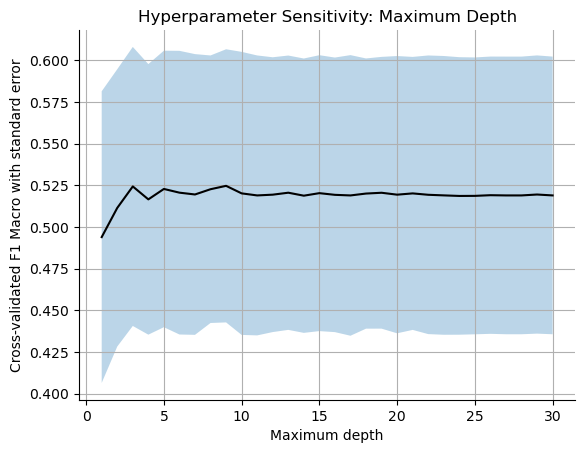

In [76]:
fig, ax = plt.subplots()
plt.plot(df_results['model_depth'],
         df_results['mean_f1macro'],
         color='k')
plt.fill_between(df_results['model_depth'], 
                 df_results['mean_f1macro']-df_results['std_f1macro'].abs(),
                 df_results['mean_f1macro']+df_results['std_f1macro'].abs(),
                 alpha=0.3)
plt.xlabel('Maximum depth')
plt.ylabel('Cross-validated F1 Macro with standard error')
plt.title('Hyperparameter Sensitivity: Maximum Depth')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True)
plt.show()

In [85]:
# --- 1. Prepare Data (Calculating Bounds) ---
# Assuming df_results is your DataFrame loaded previously

# Calculate the upper and lower bounds for the error band
df_results['upper_bound'] = df_results['mean_f1macro'] + df_results['std_f1macro'].abs()
df_results['lower_bound'] = df_results['mean_f1macro'] - df_results['std_f1macro'].abs()

# --- 2. Create Plotly Figure ---
fig = go.Figure()

# 2a. Add the Filled Area (Error Band)
# We plot the upper bound, then the lower bound in reverse, and connect them using fill='toself'
fig.add_trace(go.Scatter(
    x=df_results['model_depth'],
    y=df_results['upper_bound'],
    line=dict(width=0), # Hide the line for the upper bound
    mode='lines',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_results['model_depth'],
    y=df_results['lower_bound'],
    line=dict(width=0), # Hide the line for the lower bound
    mode='lines',
    fill='tonexty',     # Fill the area to the previous trace (the upper bound)
    fillcolor='rgba(0, 0, 0, 0.3)', # alpha=0.3 equivalent
    name='Std Error Band'
))

# 2b. Add the Mean Line
fig.add_trace(go.Scatter(
    x=df_results['model_depth'],
    y=df_results['mean_f1macro'],
    line=dict(color='black', width=2), # color='k' equivalent
    mode='lines',
    name='Mean F1 Macro'
))

# --- 3. Update Layout ---
fig.update_layout(
    title='Hyperparameter Sensitivity: Maximum Depth',
    xaxis_title='Maximum depth',
    yaxis_title='Cross-validated F1 Macro with standard error',
    # Enable grid lines (like plt.grid(True))
    # Hide top and right borders (ax.spines['top/right'].set_visible(False))
    plot_bgcolor='white',   # Sets the background color of the plotting area
    paper_bgcolor='white',  # Sets the color of the entire figure/paper area
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color (e.g., light grey)
        gridwidth=1
    ), 
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color
        gridwidth=1
    ),
    
    # Customizing axes
    xaxis_showline=True, 
    yaxis_showline=True,

)

fig.show()

In [80]:
df_results

,model_depth,mean_f1macro,std_f1macro,upper_bound,lower_bound
0,1,0.493878,0.087481,0.581359,0.406396
1,2,0.511387,0.083184,0.594572,0.428203
2,3,0.524275,0.083702,0.607977,0.440573
3,4,0.516518,0.081169,0.597686,0.435349
4,5,0.522769,0.082943,0.605712,0.439827
5,6,0.520541,0.085095,0.605636,0.435445
6,7,0.519452,0.084214,0.603666,0.435238
7,8,0.522603,0.080253,0.602855,0.442350
8,9,0.524635,0.081934,0.606570,0.442701
9,10,0.520112,0.084909,0.605021,0.435203


In [ ]:
weights = list(range(320, 360, 1))
best_params['max_depth'] = 8
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
    )
    scores = cross_val_score(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 10,
                             scoring = F1_Macro_Avg,
                             n_jobs = -1,
                             )
    mean_f1macro = np.mean(scores)
    std_f1macro= np.std(scores)
    results.append((weight, mean_f1macro, std_f1macro))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_f1macro', 'std_f1macro'])

In [92]:
# --- 1. Prepare Data (Calculating Bounds) ---
# Assuming df_results is your DataFrame loaded previously

# Calculate the upper and lower bounds for the error band
df_results['upper_bound'] = df_results['mean_f1macro'] + df_results['std_f1macro'].abs()
df_results['lower_bound'] = df_results['mean_f1macro'] - df_results['std_f1macro'].abs()

# --- 2. Create Plotly Figure ---
fig = go.Figure()

# 2a. Add the Filled Area (Error Band)
# We plot the upper bound, then the lower bound in reverse, and connect them using fill='toself'
fig.add_trace(go.Scatter(
    x=df_results['model_scale_pos_weight'],
    y=df_results['upper_bound'],
    line=dict(width=0), # Hide the line for the upper bound
    mode='lines',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_results['model_scale_pos_weight'],
    y=df_results['lower_bound'],
    line=dict(width=0), # Hide the line for the lower bound
    mode='lines',
    fill='tonexty',     # Fill the area to the previous trace (the upper bound)
    fillcolor='rgba(0, 0, 0, 0.3)', # alpha=0.3 equivalent
    name='Std Error Band'
))

# 2b. Add the Mean Line
fig.add_trace(go.Scatter(
    x=df_results['model_scale_pos_weight'],
    y=df_results['mean_f1macro'],
    line=dict(color='black', width=2), # color='k' equivalent
    mode='lines',
    name='Mean F1 Macro'
))

# --- 3. Update Layout ---
fig.update_layout(
    title='Hyperparameter Sensitivity: Scale Positive Weight',
    xaxis_title='Weight',
    yaxis_title='Cross-validated F1 Macro with standard error',
    # Enable grid lines (like plt.grid(True))
    # Hide top and right borders (ax.spines['top/right'].set_visible(False))
    plot_bgcolor='white',   # Sets the background color of the plotting area
    paper_bgcolor='white',  # Sets the color of the entire figure/paper area
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color (e.g., light grey)
        gridwidth=1
    ), 
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color
        gridwidth=1
    ),
    
    # Customizing axes
    xaxis_showline=True, 
    yaxis_showline=True,

)

fig.show()

In [93]:
df_results

,model_scale_pos_weight,mean_f1macro,std_f1macro,upper_bound,lower_bound
0,32.0,0.520006,0.081928,0.601934,0.438078
1,32.1,0.518189,0.086897,0.605087,0.431292
2,32.2,0.522350,0.083164,0.605515,0.439186
3,32.3,0.522580,0.083194,0.605774,0.439386
4,32.4,0.523296,0.081648,0.604945,0.441648
5,32.5,0.522621,0.081354,0.603974,0.441267
6,32.6,0.523093,0.081323,0.604416,0.441770
7,32.7,0.523845,0.082072,0.605916,0.441773
8,32.8,0.521682,0.081350,0.603032,0.440332
9,32.9,0.521096,0.082598,0.603694,0.438498


In [98]:
best_params['scale_pos_weight'] = 3.52
learning_rate = list(range(1, 100))
results = []
for rate in learning_rate:
    rate = rate/1000
    best_params['learning_rate'] = rate
    clf = BinaryRelevance(
        classifier= XGBClassifier(**best_params),
    )
    scores = cross_val_score(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 10,
                             scoring = F1_Macro_Avg,
                             n_jobs = -1,
                             )
    mean_f1macro = np.mean(scores)
    std_f1macro= np.std(scores)
    results.append((rate, mean_f1macro, std_f1macro))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_f1macro', 'std_f1macro'])

In [99]:
# --- 1. Prepare Data (Calculating Bounds) ---
# Assuming df_results is your DataFrame loaded previously

# Calculate the upper and lower bounds for the error band
df_results['upper_bound'] = df_results['mean_f1macro'] + df_results['std_f1macro'].abs()
df_results['lower_bound'] = df_results['mean_f1macro'] - df_results['std_f1macro'].abs()

# --- 2. Create Plotly Figure ---
fig = go.Figure()

# 2a. Add the Filled Area (Error Band)
# We plot the upper bound, then the lower bound in reverse, and connect them using fill='toself'
fig.add_trace(go.Scatter(
    x=df_results['model_learning_rate'],
    y=df_results['upper_bound'],
    line=dict(width=0), # Hide the line for the upper bound
    mode='lines',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_results['model_learning_rate'],
    y=df_results['lower_bound'],
    line=dict(width=0), # Hide the line for the lower bound
    mode='lines',
    fill='tonexty',     # Fill the area to the previous trace (the upper bound)
    fillcolor='rgba(0, 0, 0, 0.3)', # alpha=0.3 equivalent
    name='Std Error Band'
))

# 2b. Add the Mean Line
fig.add_trace(go.Scatter(
    x=df_results['model_learning_rate'],
    y=df_results['mean_f1macro'],
    line=dict(color='black', width=2), # color='k' equivalent
    mode='lines',
    name='Mean F1 Macro'
))

# --- 3. Update Layout ---
fig.update_layout(
    title='Hyperparameter Sensitivity: Learning Rate',
    xaxis_title='Learning Rate',
    yaxis_title='Cross-validated F1 Macro with standard error',
    # Enable grid lines (like plt.grid(True))
    # Hide top and right borders (ax.spines['top/right'].set_visible(False))
    plot_bgcolor='white',   # Sets the background color of the plotting area
    paper_bgcolor='white',  # Sets the color of the entire figure/paper area
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color (e.g., light grey)
        gridwidth=1
    ), 
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color
        gridwidth=1
    ),
    
    # Customizing axes
    xaxis_showline=True, 
    yaxis_showline=True,

)

fig.show()

In [100]:
df_results

,model_learning_rate,mean_f1macro,std_f1macro,upper_bound,lower_bound
0,0.001,0.534300,0.080481,0.614781,0.453819
1,0.002,0.535414,0.082179,0.617593,0.453235
2,0.003,0.527859,0.083550,0.611410,0.444309
3,0.004,0.527590,0.082641,0.610231,0.444949
4,0.005,0.529665,0.079968,0.609633,0.449697
5,0.006,0.529711,0.081188,0.610899,0.448523
6,0.007,0.531821,0.081027,0.612848,0.450794
7,0.008,0.529178,0.083898,0.613076,0.445280
8,0.009,0.523596,0.080195,0.603790,0.443401
9,0.010,0.522383,0.082282,0.604665,0.440100


In [101]:
best_params['learning_rate'] = 0.002

In [103]:
new_best_br = BinaryRelevance(
    classifier=XGBClassifier(**best_params)
)

new_best_br.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = new_best_br.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_br.toarray())

display_error_heatmap(y_train_transformed, y_pred_training_br.toarray())

display_label_cardinality_error(y_train_transformed, y_pred_training_br.toarray())


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



There are some improvements in terms of predicted label cardinality but our overal metrics score is reduced.

We will repeat the process with OneVsRestClassifier.

In [105]:
best_params = study_ovrxgb_best_params_xgb.copy()
best_params

{'n_estimators': 125,
 'max_depth': 7,
 'learning_rate': 0.030928113120891658,
 'subsample': 0.6025823757629755,
 'colsample_bytree': 0.6198233891559969,
 'scale_pos_weight': 3.421576979607886,
 'base_score': 0.5,
 'random_state': 42,
 'verbosity': 0,
 'use_label_encoder': False,
 'eval_metric': 'logloss'}

In [107]:
depths = list(range(1,31,1))
results = []
for depth in depths:
    best_params['max_depth'] = depth
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_val_score(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 10,
                             scoring = F1_Macro_Avg,
                             n_jobs = -1,
                             )
    mean_f1macro = np.mean(scores)
    std_f1macro= np.std(scores)
    results.append((depth, mean_f1macro, std_f1macro))

df_results = pd.DataFrame(results, 
                          columns=['model_depth', 'mean_f1macro', 'std_f1macro'])

In [108]:
# --- 1. Prepare Data (Calculating Bounds) ---
# Assuming df_results is your DataFrame loaded previously

# Calculate the upper and lower bounds for the error band
df_results['upper_bound'] = df_results['mean_f1macro'] + df_results['std_f1macro'].abs()
df_results['lower_bound'] = df_results['mean_f1macro'] - df_results['std_f1macro'].abs()

# --- 2. Create Plotly Figure ---
fig = go.Figure()

# 2a. Add the Filled Area (Error Band)
# We plot the upper bound, then the lower bound in reverse, and connect them using fill='toself'
fig.add_trace(go.Scatter(
    x=df_results['model_depth'],
    y=df_results['upper_bound'],
    line=dict(width=0), # Hide the line for the upper bound
    mode='lines',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_results['model_depth'],
    y=df_results['lower_bound'],
    line=dict(width=0), # Hide the line for the lower bound
    mode='lines',
    fill='tonexty',     # Fill the area to the previous trace (the upper bound)
    fillcolor='rgba(0, 0, 0, 0.3)', # alpha=0.3 equivalent
    name='Std Error Band'
))

# 2b. Add the Mean Line
fig.add_trace(go.Scatter(
    x=df_results['model_depth'],
    y=df_results['mean_f1macro'],
    line=dict(color='black', width=2), # color='k' equivalent
    mode='lines',
    name='Mean F1 Macro'
))

# --- 3. Update Layout ---
fig.update_layout(
    title='Hyperparameter Sensitivity: Maximum Depth',
    xaxis_title='Maximum depth',
    yaxis_title='Cross-validated F1 Macro with standard error',
    # Enable grid lines (like plt.grid(True))
    # Hide top and right borders (ax.spines['top/right'].set_visible(False))
    plot_bgcolor='white',   # Sets the background color of the plotting area
    paper_bgcolor='white',  # Sets the color of the entire figure/paper area
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color (e.g., light grey)
        gridwidth=1
    ), 
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color
        gridwidth=1
    ),
    
    # Customizing axes
    xaxis_showline=True, 
    yaxis_showline=True,

)

fig.show()

In [109]:
df_results

,model_depth,mean_f1macro,std_f1macro,upper_bound,lower_bound
0,1,0.493878,0.087481,0.581359,0.406396
1,2,0.511387,0.083184,0.594572,0.428203
2,3,0.524275,0.083702,0.607977,0.440573
3,4,0.516518,0.081169,0.597686,0.435349
4,5,0.522769,0.082943,0.605712,0.439827
5,6,0.520541,0.085095,0.605636,0.435445
6,7,0.519452,0.084214,0.603666,0.435238
7,8,0.522603,0.080253,0.602855,0.442350
8,9,0.524635,0.081934,0.606570,0.442701
9,10,0.520112,0.084909,0.605021,0.435203


In [110]:
weights = list(range(320, 360, 1))
best_params['max_depth'] = 9
results = []
for weight in weights:
    weight = weight/100
    best_params['scale_pos_weight'] = weight
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_val_score(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 10,
                             scoring = F1_Macro_Avg,
                             n_jobs = -1,
                             )
    mean_f1macro = np.mean(scores)
    std_f1macro= np.std(scores)
    results.append((weight, mean_f1macro, std_f1macro))

df_results = pd.DataFrame(results, 
                          columns=['model_scale_pos_weight', 'mean_f1macro', 'std_f1macro'])

In [111]:
# --- 1. Prepare Data (Calculating Bounds) ---
# Assuming df_results is your DataFrame loaded previously

# Calculate the upper and lower bounds for the error band
df_results['upper_bound'] = df_results['mean_f1macro'] + df_results['std_f1macro'].abs()
df_results['lower_bound'] = df_results['mean_f1macro'] - df_results['std_f1macro'].abs()

# --- 2. Create Plotly Figure ---
fig = go.Figure()

# 2a. Add the Filled Area (Error Band)
# We plot the upper bound, then the lower bound in reverse, and connect them using fill='toself'
fig.add_trace(go.Scatter(
    x=df_results['model_scale_pos_weight'],
    y=df_results['upper_bound'],
    line=dict(width=0), # Hide the line for the upper bound
    mode='lines',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_results['model_scale_pos_weight'],
    y=df_results['lower_bound'],
    line=dict(width=0), # Hide the line for the lower bound
    mode='lines',
    fill='tonexty',     # Fill the area to the previous trace (the upper bound)
    fillcolor='rgba(0, 0, 0, 0.3)', # alpha=0.3 equivalent
    name='Std Error Band'
))

# 2b. Add the Mean Line
fig.add_trace(go.Scatter(
    x=df_results['model_scale_pos_weight'],
    y=df_results['mean_f1macro'],
    line=dict(color='black', width=2), # color='k' equivalent
    mode='lines',
    name='Mean F1 Macro'
))

# --- 3. Update Layout ---
fig.update_layout(
    title='Hyperparameter Sensitivity: Scale Positive Weight',
    xaxis_title='Weight',
    yaxis_title='Cross-validated F1 Macro with standard error',
    # Enable grid lines (like plt.grid(True))
    # Hide top and right borders (ax.spines['top/right'].set_visible(False))
    plot_bgcolor='white',   # Sets the background color of the plotting area
    paper_bgcolor='white',  # Sets the color of the entire figure/paper area
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color (e.g., light grey)
        gridwidth=1
    ), 
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color
        gridwidth=1
    ),
    
    # Customizing axes
    xaxis_showline=True, 
    yaxis_showline=True,

)

fig.show()

In [112]:
df_results

,model_scale_pos_weight,mean_f1macro,std_f1macro,upper_bound,lower_bound
0,3.20,0.519305,0.086087,0.605391,0.433218
1,3.21,0.521223,0.083138,0.604361,0.438085
2,3.22,0.519845,0.085938,0.605783,0.433907
3,3.23,0.521318,0.085862,0.607180,0.435456
4,3.24,0.521376,0.083768,0.605144,0.437608
5,3.25,0.523084,0.084418,0.607503,0.438666
6,3.26,0.519163,0.086615,0.605778,0.432548
7,3.27,0.519069,0.087611,0.606680,0.431458
8,3.28,0.521808,0.082680,0.604488,0.439128
9,3.29,0.522075,0.083109,0.605185,0.438966


In [113]:
best_params['scale_pos_weight'] = 3.42
learning_rate = list(range(1, 100))
results = []
for rate in learning_rate:
    rate = rate/1000
    best_params['learning_rate'] = rate
    clf = OneVsRestClassifier(
        estimator = XGBClassifier(**best_params),
    )
    scores = cross_val_score(clf,
                             X_train_transformed,
                             y_train_transformed,
                             cv = 10,
                             scoring = F1_Macro_Avg,
                             n_jobs = -1,
                             )
    mean_f1macro = np.mean(scores)
    std_f1macro= np.std(scores)
    results.append((rate, mean_f1macro, std_f1macro))

df_results = pd.DataFrame(results, 
                          columns=['model_learning_rate', 'mean_f1macro', 'std_f1macro'])

In [114]:
# --- 1. Prepare Data (Calculating Bounds) ---
# Assuming df_results is your DataFrame loaded previously

# Calculate the upper and lower bounds for the error band
df_results['upper_bound'] = df_results['mean_f1macro'] + df_results['std_f1macro'].abs()
df_results['lower_bound'] = df_results['mean_f1macro'] - df_results['std_f1macro'].abs()

# --- 2. Create Plotly Figure ---
fig = go.Figure()

# 2a. Add the Filled Area (Error Band)
# We plot the upper bound, then the lower bound in reverse, and connect them using fill='toself'
fig.add_trace(go.Scatter(
    x=df_results['model_learning_rate'],
    y=df_results['upper_bound'],
    line=dict(width=0), # Hide the line for the upper bound
    mode='lines',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_results['model_learning_rate'],
    y=df_results['lower_bound'],
    line=dict(width=0), # Hide the line for the lower bound
    mode='lines',
    fill='tonexty',     # Fill the area to the previous trace (the upper bound)
    fillcolor='rgba(0, 0, 0, 0.3)', # alpha=0.3 equivalent
    name='Std Error Band'
))

# 2b. Add the Mean Line
fig.add_trace(go.Scatter(
    x=df_results['model_learning_rate'],
    y=df_results['mean_f1macro'],
    line=dict(color='black', width=2), # color='k' equivalent
    mode='lines',
    name='Mean F1 Macro'
))

# --- 3. Update Layout ---
fig.update_layout(
    title='Hyperparameter Sensitivity: Learning Rate',
    xaxis_title='Learning Rate',
    yaxis_title='Cross-validated F1 Macro with standard error',
    # Enable grid lines (like plt.grid(True))
    # Hide top and right borders (ax.spines['top/right'].set_visible(False))
    plot_bgcolor='white',   # Sets the background color of the plotting area
    paper_bgcolor='white',  # Sets the color of the entire figure/paper area
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color (e.g., light grey)
        gridwidth=1
    ), 
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey', # Set grid color
        gridwidth=1
    ),
    
    # Customizing axes
    xaxis_showline=True, 
    yaxis_showline=True,

)

fig.show()

In [115]:
df_results

,model_learning_rate,mean_f1macro,std_f1macro,upper_bound,lower_bound
0,0.001,0.534887,0.081235,0.616122,0.453652
1,0.002,0.535214,0.080590,0.615803,0.454624
2,0.003,0.533729,0.080718,0.614448,0.453011
3,0.004,0.527342,0.084253,0.611595,0.443089
4,0.005,0.528412,0.084327,0.612739,0.444085
5,0.006,0.527476,0.084507,0.611984,0.442969
6,0.007,0.528342,0.084194,0.612535,0.444148
7,0.008,0.523979,0.089393,0.613372,0.434586
8,0.009,0.522321,0.089918,0.612239,0.432403
9,0.010,0.519931,0.084559,0.604490,0.435373


In [117]:
best_params['learning_rate'] = 0.002

new_best_ovr = OneVsRestClassifier(
    estimator = XGBClassifier(**best_params)
)

new_best_ovr.fit(X_train_transformed, y_train_transformed)

y_pred_training_ovr = new_best_ovr.predict(X_train_transformed)

display_results(y_train_transformed, y_pred_training_ovr)

display_error_heatmap(y_train_transformed, y_pred_training_ovr)

display_label_cardinality_error(y_train_transformed, y_pred_training_ovr)


True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      0      0      0      0      0      0      0      1      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      1      0      0      0      1      0      1   
4      0      1      0      0      0      0      0      0      1      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       1       0       0  
4       1       0       0       1       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Feature ablation testing has to focus on major categories going into OneHotEncoder.

In [128]:
clf_list_post_tuning = [
    study_ovrxgb_tuned
]

for clf in clf_list_post_tuning:
    cross_val_results = cross_validate(clf,
                                       X_train_transformed,
                                       y_train_transformed,
                                       cv=10,
                                       scoring=scoring)

    print(f'{clf} Mean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Jaccard Samples: {cross_val_results['test_jaccard_samples'].mean()}, {cross_val_results['test_jaccard_samples'].std() }')

columns = X_train_transformed.columns.tolist()
state_columns = [col for col in columns if col.startswith('state_')]
declaration_columns = [col for col in columns if col.startswith('declarationType_')]
region_columns = [col for col in columns if col.startswith('region_')]
type_columns = [col for col in columns if col.startswith('designatedIncidentTypes_')]

drop_list = [
    state_columns,
    declaration_columns,
    region_columns,
    type_columns
]

for item_list in drop_list:
    x_train = X_train_transformed.drop(columns=item_list)

    cross_val_results = cross_validate(clf,
                                       x_train,
                                       y_train_transformed,
                                       cv=10,
                                       scoring=scoring)
    
    print(item_list)
    print(f'{clf} Mean Hamming: {cross_val_results['test_Hamming'].mean()}, {cross_val_results['test_Hamming'].std() }')
    print(f'\nMean F1 Macro Avg: {cross_val_results['test_F1_Macro_Avg'].mean()}, {cross_val_results['test_F1_Macro_Avg'].std() }')
    print(f'\nMean F1 Samples Avg: {cross_val_results['test_F1_Samples_Avg'].mean()}, {cross_val_results['test_F1_Samples_Avg'].std() }')
    print(f'\nMean Jaccard Samples: {cross_val_results['test_jaccard_samples'].mean()}, {cross_val_results['test_jaccard_samples'].std() }')

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6198233891559969,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                        

No real gains from dropping any feature sets, though surprising to see that region without state did slightly better than state without region.

This has fewer false positive but seems more prone to underestimate the number of labels than our tuned model. It even has some instances with no positive label predictions at all, which is not great for our needs.

Since we hope to provide more options for our end user to select, we will move forward with our tuned model even though this has a higher combined metrics score.

We can now load in the test set to measure performance of our tuned model.

In [48]:
df_test = pd.read_parquet('combined_test_set_nontime.parquet')
X_test, y_test = create_set(df_test, feature_columns, target_column)

In [49]:
# Split the string in designatedIncidentTypes to a list of strings.
# This cannot be done earlier due to groupby issues.
X_test['designatedIncidentTypes'] = X_test['designatedIncidentTypes'].str.split(',')
X_test.head()

,incidentId,state,designatedIncidentTypes,declarationType,region,year
0,2012102505,CT,[Hurricane],DR,1,2012.0
1,2012102505,DC,[Hurricane],EM,3,2012.0
2,2012102505,DE,[Hurricane],DR,3,2012.0
3,2012102505,DE,[Hurricane],EM,3,2012.0
4,2012102505,MD,[Hurricane],DR,3,2012.0


In [50]:
y_test.head()

0    [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
1                                                [4.0]
2                                                [7.0]
3                                                [2.0]
4                                                [7.0]
Name: supportFunction, dtype: object

In [51]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)

# X_test.drop(columns=['incidentId'], inplace=True)

# X_test_transformed = preprocessor_X.transform(X_test)
# feature_names_x = preprocessor_X.get_feature_names_out()
# X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_x)
# y_test_transformed = preprocessor_y.transform(y_test)
# feature_names_y = preprocessor_y.classes_
# y_test_transformed = pd.DataFrame(y_test_transformed, columns=feature_names_y)


In [52]:
print(X_test_transformed.shape)
X_test_transformed.head()

(101, 89)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,declarationType_DR,declarationType_EM,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,designatedIncidentTypes_Biological,designatedIncidentTypes_Chemical,designatedIncidentTypes_Coastal Storm,designatedIncidentTypes_Dam/Levee Break,designatedIncidentTypes_Earthquake,designatedIncidentTypes_Fire,designatedIncidentTypes_Flood,designatedIncidentTypes_Hurricane,designatedIncidentTypes_Mud/Landslide,designatedIncidentTypes_Other,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Depression,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
print(y_test_transformed.shape)
y_test_transformed.head()

(101, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [60]:
y_pred_test_over = study_ovrxgb_tuned.predict(X_test_transformed)

display_results(y_test_transformed, y_pred_test_over)

display_error_heatmap(y_test_transformed, y_pred_test_over)

display_label_cardinality_error(y_test_transformed, y_pred_test_over)



True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [57]:
y_proba = study_ovrxgb_tuned.predict_proba(X_test_transformed)

y_proba_adjusted = (y_proba >= 0.33).astype(int)

In [58]:
display_results(y_test_transformed, y_proba_adjusted)

display_error_heatmap(y_test_transformed, y_proba_adjusted)

display_label_cardinality_error(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [120]:
filename = 'trained_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(study_ovrxgb_tuned, file)